In [1]:
import pandas as pd

empty = pd.read_csv("empty.txt")

def is_ship(FILE_ID):
    return sum(empty["file_id"].str.contains(FILE_ID.replace(".jpg","")))==0

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from skimage import io, color
import os

%matplotlib notebook

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.measurements import find_objects, label

def detect_object(FILEPATH, EROSION = 5, THRESHOLD = .01, SIZE = 1000):
    IMGSIZE = 768
    ia = np.ndarray([IMGSIZE,IMGSIZE])
    img = plt.imread(FILEPATH)
    lum = color.rgb2lab(img)
    for x in range(IMGSIZE):
        for y in range(IMGSIZE):
            ia[x, y] = lum[x, y, 0]
    thr_low = np.sort(ia.flat)[int(IMGSIZE*IMGSIZE*THRESHOLD)]
    thr_high = np.sort(ia.flat)[int(IMGSIZE*IMGSIZE*(1-THRESHOLD))]
    for x in range(IMGSIZE):
        for y in range(IMGSIZE):
            ia[x, y] = 1 if ia[x, y] < thr_low else 1 if ia[x, y] > thr_high else 0
    ia = binary_erosion(input=ia, iterations=EROSION)
    ia = ia.astype(int)
    ia, _ = label(ia)
    objs = find_objects(ia)
    max_size = -1
    for o in range(len(objs)):
        obj = ia[objs[o]]
        size = sum((obj != 0).flat)
        max_size = max(size, max_size)
        #print(max_size)
    return (max_size >= SIZE, max_size)

def imgcolor(FILENAME, LAB = False):
    rgb = io.imread(FILENAME)

    lab = color.rgb2lab(rgb)

    l=np.mean(lab[:,:,0].flatten())
    a=np.mean(lab[:,:,1].flatten())
    b=np.mean(lab[:,:,2].flatten())
    mean = [[[l, a, b]]] if LAB else color.lab2rgb([[[l,a,b]]])*255
    return mean

def cluster(FILENAME, CLUSTERS = 4, PLOT = True):
    rgb = io.imread(FILENAME)

    lab = color.rgb2lab(rgb)

    IMGSIZE = 768
    pixels = lab.reshape(IMGSIZE**2, 3)

    kmeans = KMeans(n_clusters=CLUSTERS).fit(pixels)

    kmeans.cluster_centers_.reshape(1,CLUSTERS,3)

    _, counts = np.unique(kmeans.labels_, return_counts=True)
    counts = counts.astype(float)
    counts /= IMGSIZE**2

    l=np.mean(lab[:,:,0].flatten())
    a=np.mean(lab[:,:,1].flatten())
    b=np.mean(lab[:,:,2].flatten())
    mean = color.lab2rgb([[[l,a,b]]])*255

    rgb_main = (color.lab2rgb(kmeans.cluster_centers_.reshape(1,CLUSTERS,3))*255).reshape(CLUSTERS,3)

    carr = np.ndarray((CLUSTERS,4))
    carr[:, 0:3] = rgb_main[:, 0:] / 255
    carr[:, 3] = np.ones((1,CLUSTERS))
    
    if PLOT:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim((0,255))
        ax.set_ylim((0,255))
        ax.set_zlim((0,255))
        ax.scatter3D(xs=rgb_main[:,0],ys=rgb_main[:,1],zs=rgb_main[:,2], c=carr, s=counts*5000)
    return (rgb_main, counts, mean)



def cluster(FILENAME, CLUSTERS = 4, PLOT = True):
    rgb = io.imread(FILENAME)

    lab = color.rgb2lab(rgb)

    IMGSIZE = 768
    pixels = lab.reshape(IMGSIZE**2, 3)

    kmeans = KMeans(n_clusters=CLUSTERS).fit(pixels)

    kmeans.cluster_centers_.reshape(1,CLUSTERS,3)

    _, counts = np.unique(kmeans.labels_, return_counts=True)
    counts = counts.astype(float)
    counts /= IMGSIZE**2

    l=np.mean(lab[:,:,0].flatten())
    a=np.mean(lab[:,:,1].flatten())
    b=np.mean(lab[:,:,2].flatten())
    mean = color.lab2rgb([[[l,a,b]]])*255

    rgb_main = (color.lab2rgb(kmeans.cluster_centers_.reshape(1,CLUSTERS,3))*255).reshape(CLUSTERS,3)

    carr = np.ndarray((CLUSTERS,4))
    carr[:, 0:3] = rgb_main[:, 0:] / 255
    carr[:, 3] = np.ones((1,CLUSTERS))
    
    if PLOT:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim((0,255))
        ax.set_ylim((0,255))
        ax.set_zlim((0,255))
        ax.scatter3D(xs=rgb_main[:,0],ys=rgb_main[:,1],zs=rgb_main[:,2], c=carr, s=counts*5000)
    return (rgb_main, counts, mean)

In [2]:
_, i = detect_object("mixed/00104f16f.jpg", EROSION=2)
arr = []
arr.extend([i])

In [3]:
mean_arr_l = np.ndarray((len(os.listdir("land")),3))
mean_arr_m = np.ndarray((len(os.listdir("mixed")),3))
mean_arr_w = np.ndarray((len(os.listdir("water")),3))
mean_arr_l_lab = np.ndarray((len(os.listdir("land")),3))
mean_arr_m_lab = np.ndarray((len(os.listdir("mixed")),3))
mean_arr_w_lab = np.ndarray((len(os.listdir("water")),3))
marr = []
count_l=0
count_m=0
count_w=0
obj_size_l = []
obj_size_m = []
obj_size_w = []
i=0
for f in os.listdir("land"):
    mean = imgcolor("land/" + f)
    marr.extend("o" if is_ship(f) else "x")
    count_l += is_ship(f)
    _, obj_size = detect_object("land/"+f)
    obj_size_l.extend([obj_size])
    mean_arr_l[i,:]=mean[0][0]
    mean_lab = imgcolor("land/" + f, LAB = True)
    mean_arr_l_lab[i,:]=mean_lab[0][0]
    i += 1
    print(i)
i=0
for f in os.listdir("mixed"):
    mean = imgcolor("mixed/" + f)
    marr.extend("o" if is_ship(f) else "x")
    count_m += is_ship(f)
    _, obj_size = detect_object("mixed/"+f)
    obj_size_m.extend([obj_size])
    mean_arr_m[i,:]=mean[0][0]
    mean_lab = imgcolor("mixed/" + f, LAB = True)
    mean_arr_m_lab[i,:]=mean_lab[0][0]
    i += 1
    print(i)
i=0
for f in os.listdir("water"):
    mean = imgcolor("water/" + f)
    marr.extend("o" if is_ship(f) else "x")
    count_w += is_ship(f)
    _, obj_size = detect_object("water/"+f)
    obj_size_w.extend([obj_size])
    mean_arr_w[i,:]=mean[0][0]
    mean_lab = imgcolor("water/" + f, LAB = True)
    mean_arr_w_lab[i,:]=mean_lab[0][0]
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
1

1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796


[[ 11.63321862  22.11023592  15.79313367]
 [181.81325247 173.8522812  154.82874785]
 [ 57.7729833   65.22798828  52.72719946]
 [123.66600574 120.5395357  104.06275826]
 [ 33.73080267  65.65562491  48.41107183]
 [134.07792085  98.45478246  79.57966539]
 [ 86.21981979  89.3380431   75.398986  ]
 [ 15.21965051  42.75194832  33.37328999]]
[0.08506266 0.01726108 0.14214918 0.08769565 0.20624966 0.06962585
 0.1412184  0.25073751]
[[[55.70696428 67.70411275 54.28544497]]]


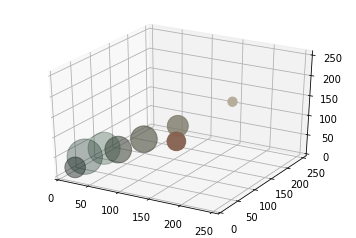

In [4]:
rgb, counts, mean = cluster("land/0097ba701.jpg", CLUSTERS=8)
print(rgb)
print(counts)
print(mean)

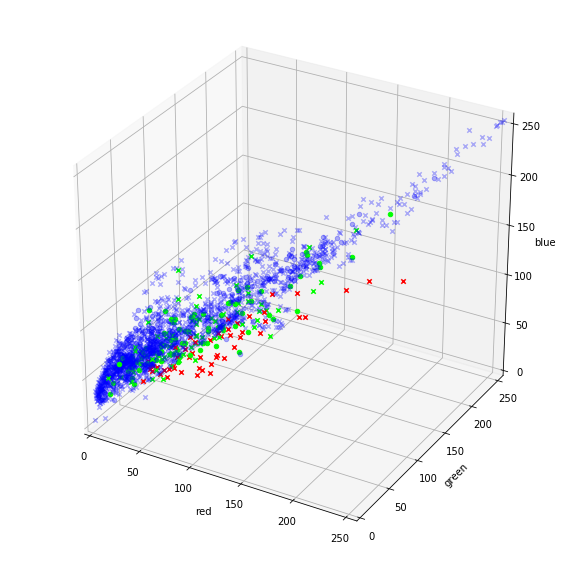

In [5]:
mean_arr = np.ndarray((len(mean_arr_l)+len(mean_arr_w)+len(mean_arr_m), 3))
mean_arr[:len(mean_arr_l)]=mean_arr_l
mean_arr[len(mean_arr_l):len(mean_arr_l)+len(mean_arr_m)]=mean_arr_m
mean_arr[-len(mean_arr_w):]=mean_arr_w
carr = np.ndarray((len(mean_arr_l)+len(mean_arr_w)+len(mean_arr_m), 4))
carr[:len(mean_arr_l)]=np.ones((len(mean_arr_l),4))*[1, 0, 0, 1]
carr[len(mean_arr_l):len(mean_arr_l)+len(mean_arr_m)]=np.ones((len(mean_arr_m),4))*[0, 1, 0, 1]
carr[-len(mean_arr_w):]=np.ones((len(mean_arr_w), 4))*[0, 0, 1, .3]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((0,255))
ax.set_xlabel("red")
ax.set_ylim((0,255))
ax.set_ylabel("green")
ax.set_zlim((0,255))
ax.set_zlabel("blue")
for i in range(len(mean_arr)):
    ax.scatter(xs=mean_arr[i,0],ys=mean_arr[i,1],zs=mean_arr[i,2], c=carr[i], marker=marr[i])

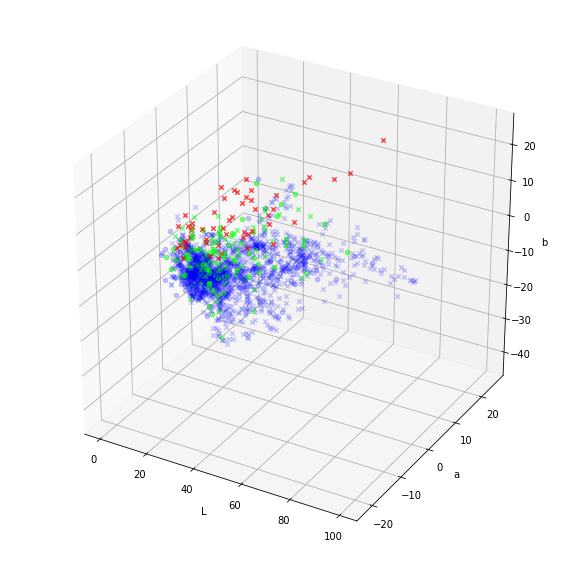

In [6]:
mean_arr_lab = np.ndarray((len(mean_arr_l)+len(mean_arr_w)+len(mean_arr_m), 3))
mean_arr_lab[:len(mean_arr_l)]=mean_arr_l_lab
mean_arr_lab[len(mean_arr_l):len(mean_arr_l)+len(mean_arr_m)]=mean_arr_m_lab
mean_arr_lab[-len(mean_arr_w):]=mean_arr_w_lab
carr = np.ndarray((len(mean_arr_l)+len(mean_arr_w)+len(mean_arr_m), 4))
carr[:len(mean_arr_l)]=np.ones((len(mean_arr_l),4))*[1, 0, 0, .7]
carr[len(mean_arr_l):len(mean_arr_l)+len(mean_arr_m)]=np.ones((len(mean_arr_m),4))*[0, 1, 0, .5]
carr[-len(mean_arr_w):]=np.ones((len(mean_arr_w), 4))*[0, 0, 1, .2]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#ax.set_xlim((0,255))
ax.set_xlabel("L")
#ax.set_ylim((0,255))
ax.set_ylabel("a")
#ax.set_zlim((0,255))
ax.set_zlabel("b")
for i in range(len(mean_arr_lab)):
    ax.scatter(xs=mean_arr_lab[i,0],ys=mean_arr_lab[i,1],zs=mean_arr_lab[i,2], c=carr[i], marker=marr[i])

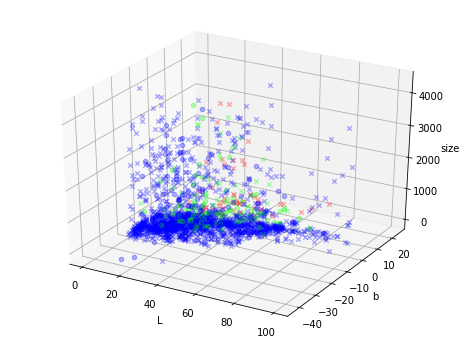

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.set_xlim((0,255))
ax.set_xlabel("L")
#ax.set_ylim((0,255))
ax.set_ylabel("b")
#ax.set_zlim((0,255))
ax.set_zlabel("size")
obj_sizes = []
obj_sizes.extend(obj_size_l)
obj_sizes.extend(obj_size_m)
obj_sizes.extend(obj_size_w)
c=0
for i in obj_size_l:
    ax.scatter(xs=mean_arr_lab[c,0],ys=mean_arr_lab[c,2],zs=i,c=[1, 0, 0, .3],marker=marr[c])
    c += 1
for i in obj_size_m:
    ax.scatter(xs=mean_arr_lab[c,0],ys=mean_arr_lab[c,2],zs=i,c=[0, 1, 0, .3],marker=marr[c])
    c += 1
for i in obj_size_w:
    ax.scatter(xs=mean_arr_lab[c,0],ys=mean_arr_lab[c,2],zs=i,c=[0, 0, 1, .3],marker=marr[c])
    c += 1
    

In [106]:
obj_sizes_log = list(map(lambda f: -1 if f <= 0 else np.log(f), obj_sizes))

[4.770684624465665,
 6.091309882077698,
 5.247024072160486,
 4.219507705176107,
 7.356279876550748,
 3.332204510175204,
 -1,
 7.291656209174461,
 7.917171988845776,
 6.897704943128636,
 7.529943370601589,
 3.6375861597263857,
 5.111987788356544,
 5.111987788356544,
 -1,
 1.3862943611198906,
 0.6931471805599453,
 6.324358962381311,
 7.498869733976931,
 6.546785410760524,
 5.703782474656201,
 7.3277805384216315,
 4.736198448394496,
 6.75110146893676,
 2.9444389791664403,
 5.056245805348308,
 4.6913478822291435,
 3.2188758248682006,
 2.8903717578961645,
 7.43543801981455,
 5.799092654460526,
 0.0,
 7.7039102096163115,
 5.934894195619588,
 4.672828834461906,
 4.7535901911063645,
 1.0986122886681098,
 3.8918202981106265,
 7.220373836723949,
 1.791759469228055,
 0.6931471805599453,
 0.0,
 8.187855443695623,
 8.19229373114764,
 4.219507705176107,
 3.044522437723423,
 5.272999558563747,
 5.755742213586912,
 6.066108090103747,
 4.820281565605037,
 4.605170185988092,
 1.6094379124341003,
 4.6347

In [107]:
with open("output.csv", "w") as f:
    f.write("l;a;b;is_ship;size\n")
    for c in range(len(obj_sizes)):
        f.write("{0};{1};{2};{3};{4}\n".format(mean_arr_lab[c,0],mean_arr_lab[c,1],mean_arr_lab[c,2],1 if marr[c]=='o' else 0,obj_sizes_log[c]))

In [108]:
import pandas as pd
df = pd.read_csv("output.csv", sep=";")

In [110]:
# Először is, az egymáshoz képest lineárisan elhelyezkedő neurális hálózat modelljét.
from keras.models import Sequential
# Szükségünk van továbbá az előrecsatolt rétegekre, illetve a rajtuk elvégzett aktivációs függvényre.
from keras.layers.core import Dense, Activation
# A Callback függvény rengeteg hasznos információt szolgáltat a tanítási folyamat során, amelyekre kíváncsiak
# szoktunk lenni. 
from keras.callbacks import Callback
# A tanulási folyamat során a széles körben alkalmazott Stochastic Gradient Descent metódust alkalmazzuk mini-batch-eken.
# Ennek segítségével tudjuk a tanulási paramétereket szabályozni.
from keras.optimizers import SGD
# A jól ismert Numpy betöltése.
import numpy as np
# Standardizáláshoz
from sklearn import preprocessing
# Matplotlib grafikus megjelenítőcsomag meghívása
import matplotlib.pyplot as plt
%matplotlib inline

# Random seed-ek beállítása
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        # Hiba mértéke a tanító adatokon.
        self.losses = []
        # Hiba mértéke a validációs adatokon.
        self.valid_losses = []
        # A modell jóságát, pontosságát mérő mutatószám a tanító adatokon. 
        self.accs = []
        # A modell jóságát, pontosságát mérő mutatószám a validációs adatokon. 
        self.valid_accs = []
        # A tanítási fázisok sorszámozása.
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()
# Modell felépítése
from keras import regularizers
# A modell struktúráját az egymásra linárisan épülő rétegek adják.
model = Sequential()
# Az első rejtett réteg definiálása, amely két bemenetről kapja az adatokat.
model.add(Dense(10, input_shape=(4,)))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# Az első rejtett réteg definiálása, amely két bemenetről kapja az adatokat.
model.add(Dense(10, input_shape=(4,)))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# Utolsó réteg definiálása, amelynek egy kimenete van.
model.add(Dense(1))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# A tanulás előtt be kell állítani, hogy a tanulási folyamat milyen paraméterek mentén történjen.
# Az első paraméter a hiba meghatározására az átlagos négyzetes hiba értéket fogjuk alkalmazni.
model.compile(loss='mean_squared_error',
              # A korábbiakban már említett SGD optimatizáló metódusban tudjuk meghatározni a tanulási rátát
              # a momemtum módszer értékét, illetve, hogy használjon a háló Nesterov-momemtum módszert.
              optimizer= SGD(lr=0.1, momentum=0.001, nesterov=True),
              metrics=['accuracy'])
nb_samples=len(list(df["l"]))
valid_split = 0.2
test_split = 0.1
samples=np.zeros(nb_samples, dtype=[('input', float, 4), ('output', float, 1)])
for i in range(nb_samples):
    samples[i] = [df["l"][i], df["a"][i], df["b"][i], df["size"][i]], df["is_ship"][i]

samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]
    
# standardizálás
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from keras.callbacks import EarlyStopping
patience=30
early_stopping=EarlyStopping(patience=patience, verbose=1)

# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

# a tanulálsi ráta (lr, learning rate) automatikus csökkentésére szolgáló függvény
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

# a tanulási ráta kézzel írt szabályok alapján történő csökkentésére szolgáló függvény
# ezt most a tanítás során nem fogjuk használni, de érdemes kipróbálni a ReduceLROnPlateau
# függvény helyett
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result=0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=10e-3
    if (epoch>60):
        result=0.1
    print("Learning rate: %f" % (result))
    return result

change_lr = LearningRateScheduler(scheduler)

In [111]:
model.fit(samples_train['input'], samples_train['output'],
          # A tanulási folyamat során beállíthatjuk, hogy a tanító adatsorból hány elem kerüljön bele egy-egy
          # batch-be.
          batch_size=20,
          # Tanulási fázisok száma.
          nb_epoch=2500,
          # Verbose paraméter a tanulás során közli azokat az információkat, amelyek mi szeretnénk kinyerni.
          # Értéke lehet 0, 1 és 2
          verbose=2, 
          # A tanulással párhuzamosan a validáció is fut.
          validation_data=(samples_valid['input'],samples_valid['output']), 
          # A korábbiakban már tárgyalt tanulást jellemző metrikákat a history nevű változóban szeretnénk tárolni.
          callbacks=[reduce_lr, checkpointer, early_stopping, history], 
          # A bemenő adatokat keverje meg a program (alapbeállítás: True).
          shuffle= True)

/home/osboxes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 1400 samples, validate on 400 samples
Epoch 1/2500
 - 0s - loss: 0.1359 - acc: 0.8329 - val_loss: 0.0889 - val_acc: 0.8875

Epoch 00001: val_loss improved from inf to 0.08893, saving model to weights.hdf5
Epoch 2/2500
 - 0s - loss: 0.1178 - acc: 0.8329 - val_loss: 0.0870 - val_acc: 0.8875

Epoch 00002: val_loss improved from 0.08893 to 0.08702, saving model to weights.hdf5
Epoch 3/2500
 - 0s - loss: 0.1165 - acc: 0.8321 - val_loss: 0.0874 - val_acc: 0.8875

Epoch 00003: val_loss did not improve from 0.08702
Epoch 4/2500
 - 0s - loss: 0.1180 - acc: 0.8350 - val_loss: 0.0878 - val_acc: 0.8850

Epoch 00004: val_loss did not improve from 0.08702
Epoch 5/2500
 - 0s - loss: 0.1156 - acc: 0.8293 - val_loss: 0.0855 - val_acc: 0.8875

Epoch 00005: val_loss improved from 0.08702 to 0.08552, saving model to weights.hdf5
Epoch 6/2500
 - 0s - loss: 0.1121 - acc: 0.8314 - val_loss: 0.0908 - val_acc: 0.8825

Epoch 00006: val_loss did not improve from 0.08552
Epoch 7/2500
 - 0s - loss: 0.1112

Epoch 57/2500
 - 0s - loss: 0.1018 - acc: 0.8479 - val_loss: 0.0770 - val_acc: 0.9100

Epoch 00057: val_loss did not improve from 0.07616
Epoch 58/2500
 - 0s - loss: 0.1012 - acc: 0.8557 - val_loss: 0.0763 - val_acc: 0.9000

Epoch 00058: val_loss did not improve from 0.07616
Epoch 59/2500
 - 0s - loss: 0.1016 - acc: 0.8550 - val_loss: 0.0770 - val_acc: 0.9100

Epoch 00059: val_loss did not improve from 0.07616
Epoch 60/2500
 - 0s - loss: 0.1011 - acc: 0.8550 - val_loss: 0.0774 - val_acc: 0.9100

Epoch 00060: val_loss did not improve from 0.07616
Epoch 61/2500
 - 0s - loss: 0.1008 - acc: 0.8557 - val_loss: 0.0777 - val_acc: 0.9075

Epoch 00061: val_loss did not improve from 0.07616
Epoch 62/2500
 - 0s - loss: 0.0993 - acc: 0.8536 - val_loss: 0.0846 - val_acc: 0.9050

Epoch 00062: val_loss did not improve from 0.07616
Epoch 63/2500
 - 0s - loss: 0.1009 - acc: 0.8543 - val_loss: 0.0766 - val_acc: 0.9075

Epoch 00063: val_loss did not improve from 0.07616
Epoch 64/2500
 - 0s - loss: 0.0997

 - 0s - loss: 0.0966 - acc: 0.8721 - val_loss: 0.0739 - val_acc: 0.9125

Epoch 00115: val_loss did not improve from 0.07319
Epoch 116/2500
 - 0s - loss: 0.0957 - acc: 0.8693 - val_loss: 0.0748 - val_acc: 0.9125

Epoch 00116: val_loss did not improve from 0.07319
Epoch 117/2500
 - 0s - loss: 0.0957 - acc: 0.8686 - val_loss: 0.0754 - val_acc: 0.9100

Epoch 00117: val_loss did not improve from 0.07319
Epoch 118/2500
 - 0s - loss: 0.0955 - acc: 0.8686 - val_loss: 0.0729 - val_acc: 0.9125

Epoch 00118: val_loss improved from 0.07319 to 0.07292, saving model to weights.hdf5
Epoch 119/2500
 - 0s - loss: 0.0959 - acc: 0.8686 - val_loss: 0.0729 - val_acc: 0.9100

Epoch 00119: val_loss improved from 0.07292 to 0.07287, saving model to weights.hdf5
Epoch 120/2500
 - 0s - loss: 0.0958 - acc: 0.8693 - val_loss: 0.0838 - val_acc: 0.8925

Epoch 00120: val_loss did not improve from 0.07287
Epoch 121/2500
 - 0s - loss: 0.0952 - acc: 0.8707 - val_loss: 0.0879 - val_acc: 0.8900

Epoch 00121: val_loss did

total ships:  288
total water:  1712
unclassified:  1293
pred(ship), real(ship):  99
pred(ship), real(water):  31
pred(water), real(ship):  5
pred(water), real(water):  572
dataset reduced by:  0.2885
ships lost:  0.017361111111111112


(array([ 32., 379., 794., 251., 154., 124., 105.,  75.,  66.,  20.]),
 array([-0.2082544 , -0.11184653, -0.01543866,  0.0809692 ,  0.17737707,
         0.27378494,  0.3701928 ,  0.46660067,  0.56300853,  0.6594164 ,
         0.75582427]),
 <a list of 10 Patch objects>)

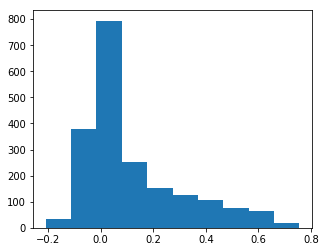

In [113]:
fig=plt.figure(figsize=(5,4))
hist_arr=model.predict(samples["input"]).ravel().astype(float)
spacing = np.linspace(0,1,20)
hbin = []
pred_ship_real_water = 0
pred_water_real_ship = 0
pred_ship_real_ship = 0
pred_water_real_water = 0
i = 0
total_ships = 0
for i in range(len(hist_arr)):
    real_ship = marr[i] == 'o'
    if real_ship:
        total_ships += 1
    pred_ship = hist_arr[i] >= .5
    pred_water = hist_arr[i] < 0
    if real_ship and pred_ship:
        pred_ship_real_ship += 1
    if real_ship and pred_water:
        pred_water_real_ship += 1
    if not real_ship and pred_water:
        pred_water_real_water += 1
    if not real_ship and pred_ship:
        pred_ship_real_water += 1
    i += 1
print("total ships: ", total_ships)
print("total water: ", len(hist_arr)-total_ships)
print("unclassified: ", len(hist_arr)-pred_ship_real_ship-pred_water_real_ship-pred_ship_real_water-pred_water_real_water)
print("pred(ship), real(ship): ", pred_ship_real_ship)
print("pred(ship), real(water): ", pred_ship_real_water)
print("pred(water), real(ship): ", pred_water_real_ship)
print("pred(water), real(water): ", pred_water_real_water)
print("dataset reduced by: ", (pred_water_real_ship+pred_water_real_water)/len(hist_arr))
print("ships lost: ", pred_water_real_ship/total_ships)
plt.hist(hist_arr)

In [42]:
hist_arr=model.predict(samples["input"]).ravel().astype(float)
hist_arr

array([0.80324328, 0.73464447, 0.95256311, ..., 0.66034245, 0.93400776,
       0.56566536])